<a href="https://colab.research.google.com/github/SorrowAddict/SK-FLY-AI/blob/main/AI_Learning/Week-03_DACON_AI_Training/240102_%EB%B2%95%EC%9B%90_%ED%8C%90%EA%B2%B0_%EC%98%88%EC%B8%A1_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 한글 처리

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

# 법원 판결 예측 과제

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import re

from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from imblearn.under_sampling import NeighbourhoodCleaningRule

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
# Fix Seed
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(42)

In [ ]:
train = pd.read_csv('train.csv').drop('ID', axis=1)
test = pd.read_csv('test.csv').drop('ID', axis=1)
submission = pd.read_csv('sample_submission.csv')

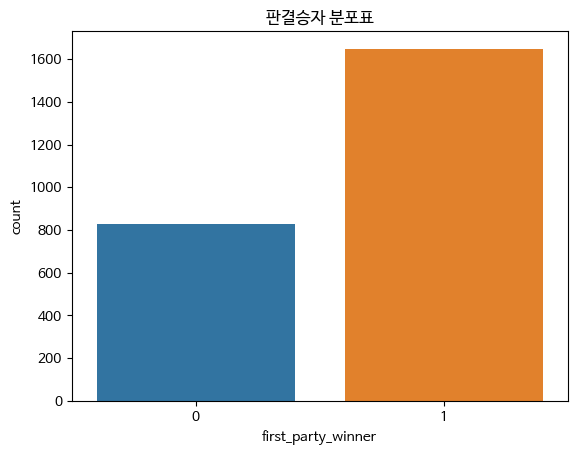

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# first_party_winner에 대한 countplot
sns.countplot(x='first_party_winner', data=train)
plt.title('판결승자 분포표')
plt.show()

In [ ]:
train.head()

,first_party,second_party,facts,first_party_winner
0,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1


In [ ]:
test.head()

,first_party,second_party,facts
0,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...
1,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...
2,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa..."
3,Harold Kaufman,United States,During his trial for armed robbery of a federa...
4,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a..."


In [ ]:
train.isnull().sum()

first_party           0
second_party          0
facts                 0
first_party_winner    0
dtype: int64

In [ ]:
submission.head()

,ID,first_party_winner
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


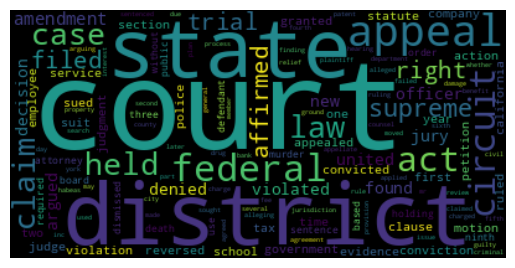

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

text = train['facts'].tolist()
text = ' '.join(text).lower()

wordcloud = WordCloud(stopwords=STOPWORDS, collocations=False, min_word_length=2).generate(text)

#plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')

plt.show()

In [ ]:
from collections import Counter

# 단어 빈도 계산
word_freq = Counter(wordcloud.words_)

# 상위 10개 출력
top_10_words = word_freq.most_common(10)
for word, freq in top_10_words:
    print(f'{word}: {freq}')

court: 1.0
district: 0.3586121157323689
state: 0.32798372513562385
appeal: 0.3111437613019892
federal: 0.21417269439421338
circuit: 0.19688065099457505
act: 0.17970162748643762
held: 0.13912748643761302
claim: 0.13664104882459313
case: 0.1337025316455696


### Data Preprocessing

- 소문자 변환, NLTK의 영어 불용어 사용, 공백 나누기

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 전처리 함수 정의
def preprocess_text(text):
    # 여기서 text에 대한 원하는 전처리 작업을 수행합니다.
    # 예: 특수문자 제거, 소문자 변환 등
    processed_text = text.lower()  # 예시로 소문자 변환

    return processed_text

# TfidfVectorizer 설정
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x.split(),  # 공백을 기준으로 단어를 나누는 tokenizer 사용
    stop_words='english',  # NLTK의 영어 불용어 사용
    preprocessor=preprocess_text  # 사용자 정의 전처리 함수 적용
)

# 벡터화 함수 업데이트
def get_vector(vectorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['facts'])
    else:
        X_facts = vectorizer.transform(df['facts'])
    X_party1 = vectorizer.transform(df['first_party'])
    X_party2 = vectorizer.transform(df['second_party'])

    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X

In [ ]:
# 데이터 벡터화
X_train = get_vector(vectorizer, train, True)
Y_train = train["first_party_winner"]
X_test = get_vector(vectorizer, test, False)
# X_train.voca

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Data Preprocessing

Training Accuracy: 0.9430
Validation Accuracy: 0.6452
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.12      0.19       168
           1       0.67      0.91      0.77       328

    accuracy                           0.65       496
   macro avg       0.54      0.52      0.48       496
weighted avg       0.58      0.65      0.57       496

Confusion Matrix:
 [[ 20 148]
 [ 28 300]]


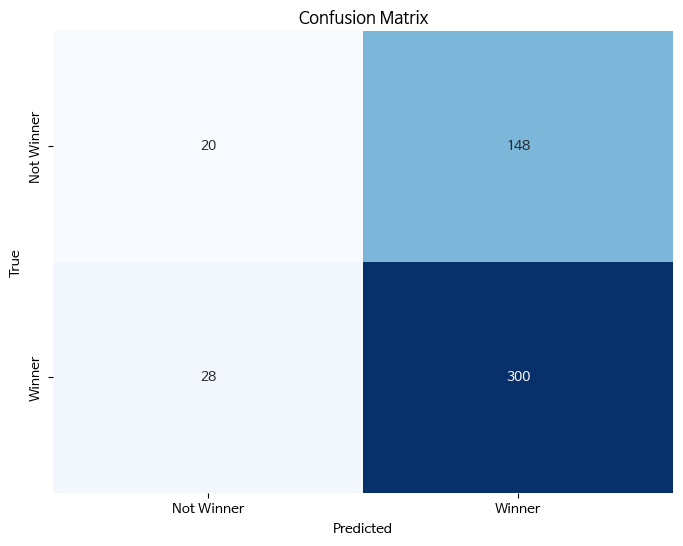

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# TF-IDF 벡터화는 이미 수행되었다고 가정
# X_train, Y_train, X_test는 이미 벡터화된 상태로 주어진다고 가정

# 데이터 분할 (검증 데이터)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 생성 및 훈련
logreg_model = LogisticRegression()
logreg_model.fit(np.asarray(X_train), np.asarray(Y_train))

# 훈련 데이터를 사용한 예측
Y_train_pred = logreg_model.predict(np.asarray(X_train))
# 검증 데이터를 사용한 예측
Y_val_pred = logreg_model.predict(np.asarray(X_val))

# 정확도 평가
train_accuracy = accuracy_score(Y_train, Y_train_pred)
accuracy = accuracy_score(Y_val, Y_val_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# 분류 보고서 출력
print("Classification Report:\n", classification_report(Y_val, Y_val_pred))

# 혼동 행렬 출력
conf_matrix = confusion_matrix(Y_val, Y_val_pred)
print("Confusion Matrix:\n", conf_matrix)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Winner', 'Winner'], yticklabels=['Not Winner', 'Winner'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
submission['first_party_winner'] = logreg_model.predict(np.asarray(X_test))
submission.to_csv('logistic_predict_03.csv', index=False)

### 랜덤 포레스트 모델

Training Accuracy: 0.9445
Validation Accuracy: 0.9370
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91       145
           1       0.91      1.00      0.95       252

    accuracy                           0.94       397
   macro avg       0.95      0.91      0.93       397
weighted avg       0.94      0.94      0.94       397

Confusion Matrix:
 [[120  25]
 [  0 252]]


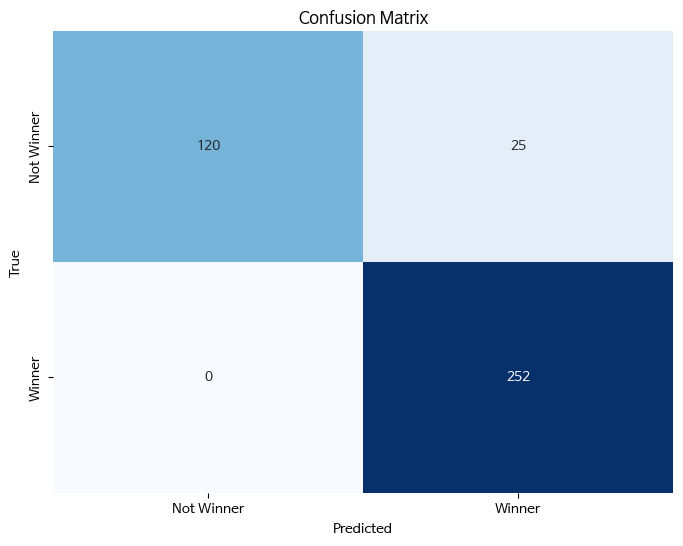

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 데이터 분할 (검증 데이터)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 생성 및 훈련
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(np.asarray(X_train), np.asarray(Y_train))

# 훈련 데이터를 사용한 예측
Y_train_pred = logreg_model.predict(np.asarray(X_train))
# 검증 데이터를 사용한 예측
Y_val_pred = logreg_model.predict(np.asarray(X_val))

# 정확도 평가
train_accuracy = accuracy_score(Y_train, Y_train_pred)
accuracy = accuracy_score(Y_val, Y_val_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# 분류 보고서 출력
print("Classification Report:\n", classification_report(Y_val, Y_val_pred))

# 혼동 행렬 출력
conf_matrix = confusion_matrix(Y_val, Y_val_pred)
print("Confusion Matrix:\n", conf_matrix)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Winner', 'Winner'], yticklabels=['Not Winner', 'Winner'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
submission['first_party_winner'] = logreg_model.predict(np.asarray(X_test))
submission.to_csv('randomforest_predict_02.csv', index=False)

### SVM 모델

In [ ]:
from sklearn.svm import SVC

# 데이터 분할 (검증 데이터)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# SVM 모델 생성 및 훈련
svm_model = SVC(random_state=42)
svm_model.fit(np.asarray(X_train), np.asarray(Y_train))

# 훈련 데이터를 사용한 예측
Y_train_pred = logreg_model.predict(np.asarray(X_train))
# 검증 데이터를 사용한 예측
Y_val_pred = logreg_model.predict(np.asarray(X_val))

# 정확도 평가
train_accuracy = accuracy_score(Y_train, Y_train_pred)
accuracy = accuracy_score(Y_val, Y_val_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# 분류 보고서 출력
print("Classification Report:\n", classification_report(Y_val, Y_val_pred))

# 혼동 행렬 출력
conf_matrix = confusion_matrix(Y_val, Y_val_pred)
print("Confusion Matrix:\n", conf_matrix)


### 그래디언트 부스팅 모델

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# 데이터 분할 (검증 데이터)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# 그래디언트 부스팅 모델 생성 및 훈련
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(np.asarray(X_train), np.asarray(Y_train))

# 훈련 데이터를 사용한 예측
Y_train_pred = logreg_model.predict(np.asarray(X_train))
# 검증 데이터를 사용한 예측
Y_val_pred = logreg_model.predict(np.asarray(X_val))

# 정확도 평가
train_accuracy = accuracy_score(Y_train, Y_train_pred)
accuracy = accuracy_score(Y_val, Y_val_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# 분류 보고서 출력
print("Classification Report:\n", classification_report(Y_val, Y_val_pred))

# 혼동 행렬 출력
conf_matrix = confusion_matrix(Y_val, Y_val_pred)
print("Confusion Matrix:\n", conf_matrix)


Validation Accuracy: 0.6601
Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.05      0.08        59
           1       0.70      0.91      0.79       144

    accuracy                           0.66       203
   macro avg       0.44      0.48      0.44       203
weighted avg       0.55      0.66      0.58       203

Confusion Matrix:
 [[  3  56]
 [ 13 131]]


### Inference & Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')

In [ ]:
pred = model.predict(X_test)

In [ ]:
submit['first_party_winner'] = pred
submit.to_csv('./baseline_submit.csv', index=False)
print('Done')

# 데이터 전처리 시도
## stopwords 등